In [1]:
import pandas as pd
import numpy as np
import re, pickle
%matplotlib inline

In [2]:
listf = "list.txt"
relsf = "rels.txt"
entdicf = "../dbpedia/dbpcore.nt.entdic.ssd"
reldicf = "../dbpedia/dbpcore.nt.reldic.ssd"
reltenf = "../dbpedia/dbpcore.nt.relten.dok"
relmatf = "../dbpedia/dbpcore.nt.relmat.dok"

### Transform .csv of strings to a list of id's

In [3]:
seed = pd.read_csv("list.txt")

In [4]:
def loadDic(entdicf):
    entdic = {}
    for line in open(entdicf):
        splits = line.split(" ")
        entdic[splits[0]] = int(splits[1])
    return entdic

In [5]:
entdic = loadDic(entdicf)
reldic = loadDic(reldicf)

In [6]:
seed = {entdic[x] for x in list(seed["s"].values) if x in entdic}

In [7]:
len(seed)

1542

### Get the desired relation ids

In [8]:
rels = set()
for line in open(relsf):
    rels.add(int(line))

In [9]:
rels

{20, 25, 46, 47, 49, 50, 186, 204, 328, 476}

### Get properties of the seed, only with the desired relations

In [10]:
def getrels(reltenf, seed, rels):
    accf = []
    acci = []
    c = 0
    for line in open(reltenf):
        c += 1
        if c % 10000000 == 0:
            print c
        ns = tuple([int(x) for x in line.split(" ")])
        if len(ns) == 3 and (ns[0] in seed) and ns[1] in rels:
            accf.append(ns)
        elif len(ns) == 3 and (ns[2] in seed) and ns[1] in rels:
            acci.append(ns)
    return accf, acci

accf, acci = getrels(reltenf, seed, rels)

10000000
20000000
30000000
40000000


In [11]:
accf[:5]

[(2384, 46, 8586),
 (2384, 47, 8586),
 (2384, 49, 6258),
 (2384, 49, 690216),
 (2384, 49, 376850)]

In [12]:
df = pd.DataFrame(accf)
df.columns = ["s", "r", "o"]

In [13]:
newentities = set(df["o"].unique())#.union(set(df["o"].unique()))
len(newentities)

6201

### Get second hop

In [14]:
acc2f, acc2i = getrels(reltenf, newentities, rels)

10000000
20000000
30000000
40000000


In [15]:
df2 = pd.DataFrame(acc2f)
df2.columns = ["s", "r", "o"]
newentities = set(df2["o"].unique())

### Get third hop

In [16]:
acc3f, acc3i = getrels(reltenf, newentities, rels)

10000000
20000000
30000000
40000000


In [17]:
df3 = pd.DataFrame(acc3f)
df3.columns = ["s", "r", "o"]
# df3

### Merge

In [18]:
adf = pd.concat([df, df2, df3])
adf.reset_index(drop=True, inplace=True)
# adf

In [19]:
allentities = set(adf["s"].unique()).union(set(adf["o"].unique()))

In [20]:
len(allentities)

11298

In [24]:
adf.groupby("s").count().groupby("r").count()
adf.sort_values(by="s")

,s,r,o
33080,618,20,8263
33079,618,20,181011
29991,618,20,8263
29990,618,20,181011
12647,718,20,93103
12648,718,20,3674401
23222,718,20,93103
12649,718,25,88024
12650,733,20,9622
12651,733,20,8938


### Get all relations (both forward and reverse) of the subset of all involved entities

In [25]:
allfwdrels = {}
c = 0
for line in open(relmatf):
    if c % 10000000 == 0:
        print c
    c += 1
    s, r = [int(x) for x in line.split(" ") if " " in line and len(line) > 2]
    if s == 0 and r== 1400:
        print c
    if s in allentities:
        if s not in allfwdrels:
            allfwdrels[s] = set()
        allfwdrels[s].add(r)
    

0
10000000
20000000
30000000
40000000
50000000
60000000
70000000


In [26]:
fwdrell = []
for x, v in sorted(allfwdrels.items()):
    for ve in sorted(v):
        fwdrell.append((x,ve))
        
fwdreldf = pd.DataFrame(fwdrell)
fwdreldf.columns = ["e", "r"]
fwdreldf["d"] = "F"

In [27]:
fwdreldf.describe()

,e,r
count,422561.000000,422561.000000
mean,562132.625114,2384.696735
std,961469.727056,7261.871378
min,2.000000,0.000000
25%,35895.000000,95.000000
50%,110424.000000,1557.000000
75%,562543.000000,2159.000000
max,5380124.000000,60135.000000


In [28]:
allrevrels = {}
c = 0
for line in open(reltenf):
    if c % 10000000 == 0:
        print c
    c += 1
    s, r, o = [int(x) for x in line.split(" ") if " " in line and len(line) > 4]
    if o in allentities:
        if o not in allrevrels:
            allrevrels[o] = set()
        allrevrels[o].add(r)

0
10000000
20000000
30000000
40000000


In [29]:
revrell = []
for x, v in sorted(allrevrels.items()):
    for ve in sorted(v):
        revrell.append((x,ve))
        
revreldf = pd.DataFrame(revrell)
revreldf.columns = ["e", "r"]
revreldf["d"] = "R"

In [30]:
allreldf = pd.concat([fwdreldf, revreldf])

array([    0,     8,  1360, ..., 12806,  4806,  5648])

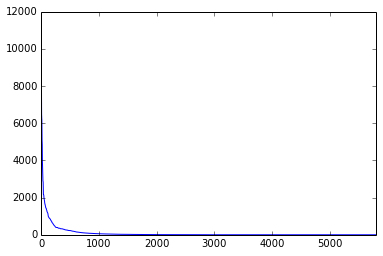

In [31]:
allreldf.groupby("r").count().sort_values("e", ascending=False)["e"].reset_index(drop=True).plot()
allreldf.groupby("r").count().sort_values("e", ascending=False).reset_index()["r"].unique()

take the top 500

In [32]:
freqrels = list(allreldf.groupby("r").count()
               .sort_values("e", ascending=False)["e"]
               .reset_index()[:500]["r"].values)
print rels.difference(freqrels)
# freqrels = freqrels.union(rels)
len(freqrels)

set([])


500

### Change dictionaries

In [33]:
entidxs = range(len(allentities))
imentdic = dict(zip(allentities, entidxs))
relidxs = range(1,len(freqrels)+1)
imreldic = dict(zip(freqrels, relidxs))

In [34]:
print 417 in allentities
print 1400 in freqrels

False
False


In [35]:
# reverse original dictionary
inventdic = {v: k for k, v in entdic.items()}
invreldic = {v: k for k, v in reldic.items()}

In [36]:
newentdic = {}
for k in imentdic:
    newentdic[inventdic[k]] = imentdic[k]
newreldic = {}
for k in imreldic:
    newreldic[invreldic[k]] = imreldic[k]

In [37]:
print newentdic["http://dbpedia.org/resource/Gregg_Toland"]
print inventdic[184245]
print imentdic[184245]

9440
http://dbpedia.org/resource/Gregg_Toland
9440


### Transform triples with new dictionaries

In [38]:
adf["s"] = adf["s"].map(lambda x: imentdic[x])
adf["r"] = adf["r"].map(lambda x: imreldic[x])
adf["o"] = adf["o"].map(lambda x: imentdic[x])

In [39]:
print adf.min()
print adf.max()
print invreldic[1400]
print inventdic[0]
allreldf[allreldf.r == 1400]

s    1
r    4
o    0
dtype: int64
s    11297
r      409
o    11297
dtype: int64
http://dbpedia.org/property/flag
http://dbpedia.org/resource/Rockall


,e,r,d
4,2,1400,F
47,576,1400,F
294,625,1400,F
373,677,1400,F
1481,1163,1400,F
1842,1606,1400,F
2519,1718,1400,F
2937,1751,1400,F
3828,1843,1400,F
5561,2398,1400,F


In [40]:
sreldf = allreldf[(allreldf.r.isin(freqrels))].reset_index(drop=True)

In [41]:
sreldf[sreldf.e == 0]
0 in imentdic

False

In [42]:
sreldf["e"] = sreldf["e"].map(lambda x: imentdic[x])
sreldf["r"] = sreldf["r"].map(lambda x: imreldic[x])

### Save triples and new dictionaries

In [44]:
pickle.dump(adf, open("triples3hops.pd.pkl","w"))
pickle.dump(sreldf, open("allrel3hops.pd.pkl", "w"))
pickle.dump(newentdic, open("entdic3hops.pkl","w"))
pickle.dump(newreldic, open("reldic3hops.pkl","w"))